<a href="https://colab.research.google.com/github/HLF2005/waste-classification-cnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

# (Optionnel) Éviter d'allouer toute la VRAM d'un coup
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print('Memory growth non appliqué:', e)

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth non appliqué: Physical devices cannot be modified after being initialized


In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil
SRC_DRIVE = '/content/drive/MyDrive/dataset/dataset'  # <-- adaptez si nécessaire
DST_LOCAL = '/content/dataset'

if not os.path.exists(SRC_DRIVE):
    raise FileNotFoundError(f"Chemin introuvable: {SRC_DRIVE}")

if os.path.exists(DST_LOCAL):
    print('Dataset déjà copié en local:', DST_LOCAL)
else:
    print('Copie du dataset...')
    shutil.copytree(SRC_DRIVE, DST_LOCAL)
    print('Copie terminée ->', DST_LOCAL)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset déjà copié en local: /content/dataset


In [53]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List

np.random.seed(0)

# Chemin local
DATASET_PATH = '/content/dataset'

# Classes (adapter à votre dataset)
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}

BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
EPOCHS = 50  # Ajustez si besoin
AUTOTUNE = tf.data.AUTOTUNE

In [54]:
def list_image_paths(root: str):
    exts = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
    paths, labels = [], []
    for cls in CLASSES:
        cls_dir = os.path.join(root, cls)
        if not os.path.isdir(cls_dir):
            raise FileNotFoundError(f"Dossier classe manquant: {cls_dir}")
        for f in os.listdir(cls_dir):
            if f.endswith(exts):
                paths.append(os.path.join(cls_dir, f))
                labels.append(CLASS2IDX[cls])
    paths = np.array(paths)
    labels = np.array(labels)
    # shuffle global
    idx = np.random.permutation(len(paths))
    return paths[idx], labels[idx]

paths, labels = list_image_paths(DATASET_PATH)
n = len(paths)
print('Total images détectées:', n)
if n == 0:
    raise RuntimeError('Aucune image détectée. Vérifiez DATASET_PATH et extensions.')

split1, split2 = int(0.6*n), int(0.8*n)
train_p, train_y = paths[:split1], labels[:split1]
val_p,   val_y   = paths[split1:split2], labels[split1:split2]
test_p,  test_y  = paths[split2:], labels[split2:]

len(train_p), len(val_p), len(test_p)


Total images détectées: 2527


(1516, 505, 506)

In [55]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE, method='bilinear')
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

def make_ds(p, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((p, y))
    if training:
        ds = ds.shuffle(min(4096, len(p)), reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_p, train_y, training=True)
val_ds   = make_ds(val_p, val_y, training=False)
test_ds  = make_ds(test_p, test_y, training=False)

for batch_imgs, batch_labels in train_ds.take(1):
    print('Batch images shape:', batch_imgs.shape)
    print('Batch labels shape:', batch_labels.shape)

Batch images shape: (16, 128, 128, 3)
Batch labels shape: (16, 6)


In [56]:
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(128, 128, 3))

    # Bloc 1
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.20)(x)

    # Bloc 2
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.20)(x)

    # Bloc 3
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_model()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.02)  # ou 0.0 si tu préfères
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es  = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=3e-5)

In [57]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=2
)

Epoch 1/50
95/95 - 20s - 211ms/step - accuracy: 0.2639 - loss: 1.6893 - val_accuracy: 0.3723 - val_loss: 1.5752
Epoch 2/50
95/95 - 3s - 32ms/step - accuracy: 0.3232 - loss: 1.5875 - val_accuracy: 0.2792 - val_loss: 1.5743
Epoch 3/50
95/95 - 4s - 46ms/step - accuracy: 0.3496 - loss: 1.5546 - val_accuracy: 0.3129 - val_loss: 1.6567
Epoch 4/50
95/95 - 3s - 28ms/step - accuracy: 0.3714 - loss: 1.5276 - val_accuracy: 0.4455 - val_loss: 1.4088
Epoch 5/50
95/95 - 2s - 24ms/step - accuracy: 0.4109 - loss: 1.4295 - val_accuracy: 0.4158 - val_loss: 1.3844
Epoch 6/50
95/95 - 3s - 35ms/step - accuracy: 0.4446 - loss: 1.3709 - val_accuracy: 0.4792 - val_loss: 1.3442
Epoch 7/50
95/95 - 4s - 47ms/step - accuracy: 0.4710 - loss: 1.3309 - val_accuracy: 0.4871 - val_loss: 1.2597
Epoch 8/50
95/95 - 2s - 23ms/step - accuracy: 0.4908 - loss: 1.2936 - val_accuracy: 0.4317 - val_loss: 1.3541
Epoch 9/50
95/95 - 2s - 23ms/step - accuracy: 0.5475 - loss: 1.2156 - val_accuracy: 0.5604 - val_loss: 1.1430
Epoch 10

In [58]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.7079042792320251
Test accuracy: 0.782608687877655


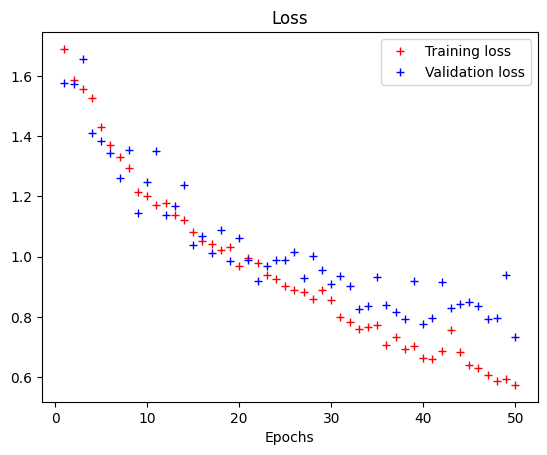

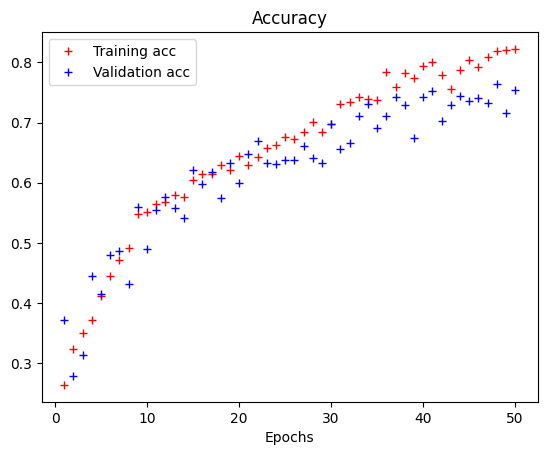

In [59]:
epochs = range(1, len(history.history['loss'])+1)
plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'r+', label='Training loss')
plt.plot(epochs, history.history.get('val_loss', []), 'b+', label='Validation loss')
plt.legend(); plt.xlabel('Epochs'); plt.show()

plt.figure()
plt.title('Accuracy')
plt.plot(epochs, history.history['accuracy'], 'r+', label='Training acc')
plt.plot(epochs, history.history.get('val_accuracy', []), 'b+', label='Validation acc')
plt.legend(); plt.xlabel('Epochs'); plt.show()


In [60]:
model.save("best_model_128x128.h5")

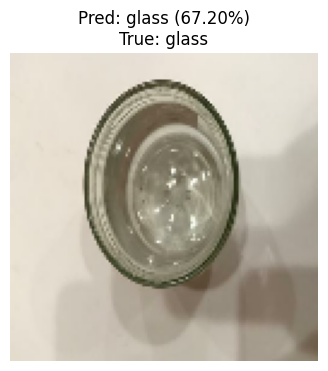

Image : /content/dataset/glass/glass153.jpg
Top-3 prédictions :
 - glass: 67.20%
 - metal: 30.03%
 - trash: 1.37%


In [77]:
import os, random, glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Utilitaires ---
def load_img_for_model(path, image_size):
    img_raw = tf.io.read_file(path)
    img = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, image_size, method='bilinear')
    img = tf.cast(img, tf.float32) / 255.0
    return img

def pick_random_image():
    # 1) Si le notebook a des chemins test_p (définis plus tôt), on s'en sert
    try:
        if isinstance(test_p, (list, np.ndarray)) and len(test_p) > 0:
            return random.choice(list(test_p))
    except NameError:
        pass

    # 2) Sinon, on pioche n'importe où dans DATASET_PATH
    exts = ['*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG']
    all_imgs = []
    for cls in CLASSES:
        for ext in exts:
            all_imgs.extend(glob.glob(os.path.join(DATASET_PATH, cls, ext)))
    if not all_imgs:
        raise RuntimeError("Aucune image trouvée. Vérifie DATASET_PATH et l'arborescence.")
    return random.choice(all_imgs)

# --- Tirage, prédiction & affichage ---
rand_path = pick_random_image()
img = load_img_for_model(rand_path, IMAGE_SIZE)
pred = model.predict(tf.expand_dims(img, 0), verbose=0)[0]  # (num_classes,)
top3_idx = np.argsort(pred)[::-1][:3]
top3 = [(CLASSES[i], float(pred[i])) for i in top3_idx]

# Titre (classe vraie si déductible du chemin)
true_label = None
parts = os.path.normpath(rand_path).split(os.sep)
for c in CLASSES:
    if c in parts:
        true_label = c
        break

plt.figure(figsize=(4,4))
plt.imshow(img.numpy())
plt.axis('off')
title = f"Pred: {CLASSES[top3_idx[0]]} ({pred[top3_idx[0]]:.2%})"
if true_label is not None:
    title += f"\nTrue: {true_label}"
plt.title(title)
plt.show()

print("Image :", rand_path)
print("Top-3 prédictions :")
for cls, p in top3:
    print(f" - {cls}: {p:.2%}")